### Import Libaries:

In [29]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from datetime import datetime
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_digits
from matplotlib.path import Path
import matplotlib.patches as patches
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from collections import Counter
%matplotlib inline

### Import listings, clean data, extract features

In [16]:
# Read in the data 
listings = pd.read_csv('datasets/listings.csv', delimiter=',')
calendar = pd.read_csv('datasets/calendar.csv', delimiter=',', usecols=range(4))

# View feature list
print listings.columns.values

['id' 'scrape_id' 'last_scraped' 'name' 'picture_url' 'host_id' 'host_name'
 'host_since' 'host_picture_url' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'city' 'state' 'zipcode' 'market' 'country'
 'latitude' 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'guests_included' 'extra_people'
 'minimum_nights' 'maximum_nights' 'calendar_updated' 'availability_30'
 'availability_60' 'availability_90' 'availability_365'
 'calendar_last_scraped' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count']


In [17]:
# Unsuppress Output
pd.options.display.max_columns = 70

# Split into predictor and response
y = listings[['price']]
x = listings
del x['price']
x = x.join(y)


# Show predictor df
print 'Predictor Data Shape: ', x.shape
x.head(n = 3)

Predictor Data Shape:  (27392, 52)


,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,weekly_price,monthly_price,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,2.015010e+13,1/2/15,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,4/10/13,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",Midtown East,Midtown East,New York,NY,10022-4175,New York,United States,40.756852,-73.964754,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,"$1,000.00",NaN,2,$0.00,3,14,3 weeks ago,21,51,72,322,1/2/15,62,4/28/13,12/17/14,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,$160.00
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",Hamilton Heights,Hamilton Heights,New York,NY,NaN,New York,United States,40.830599,-73.941014,f,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,NaN,NaN,NaN,1,$50.00,1,180,4 days ago,28,58,88,348,1/2/15,22,1/5/14,12/29/14,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,$105.00
2,2061725,2.015010e+13,1/2/15,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,1/5/13,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",Bushwick,Bushwick,Brooklyn,NY,11221,New York,United States,40.692189,-73.924120,t,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,NaN,NaN,NaN,1,$12.00,3,30,today,4,13,26,227,1/2/15,35,2/4/14,12/29/14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,$58.00


For our baseline model, we can start by removing features that we intuitively sense will not impact a listing's price. This includes 11 features.

In [18]:
del x['scrape_id']
del x['last_scraped'] # all within first three days of January, not necessary feature
del x['picture_url']
del x['host_picture_url']
del x['neighbourhood'] # neighbourhood_cleansed is in a better format
del x['state'] # all NY
del x['market'] # all New York
del x['country'] # all United States
del x['weekly_price'] # function of daily price
del x['monthly_price'] # function of daily price
del x['calendar_last_scraped'] # all within first three days of January, not necessary feature

print 'Predictor Data Shape: ', x.shape

Predictor Data Shape:  (27392, 41)


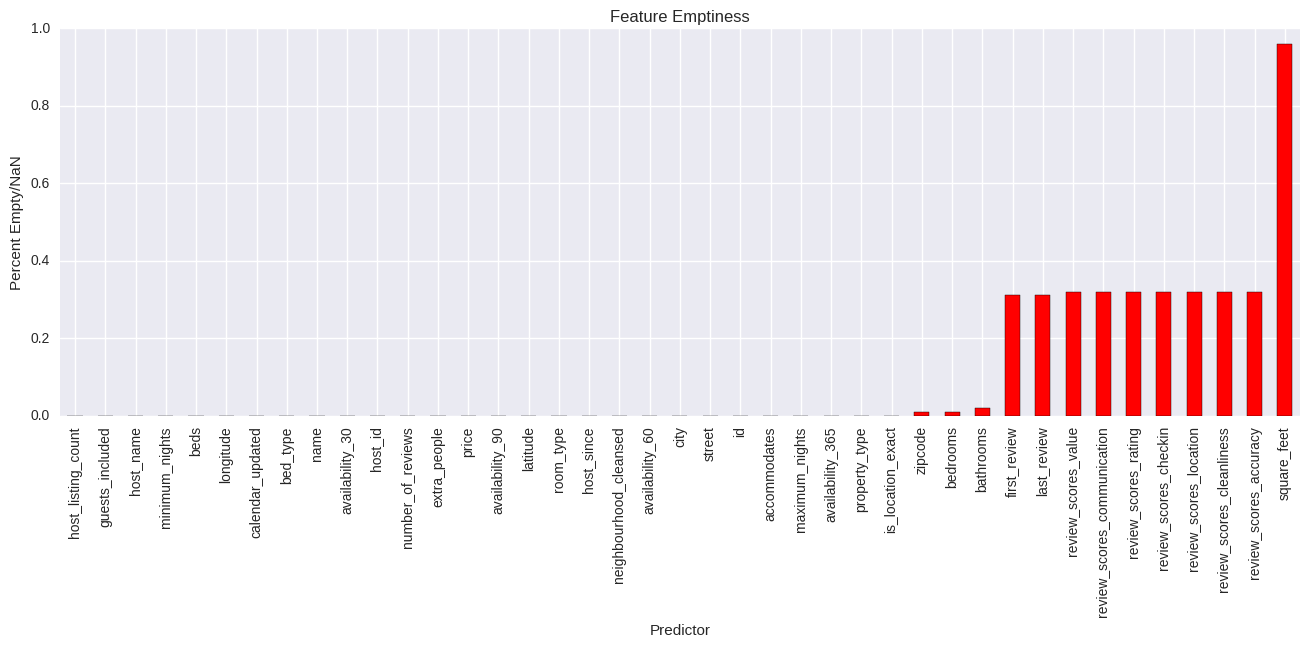

In [19]:
# Returns percent of missing data in column
def percent_empty(df):
    bools = df.isnull().tolist()
    percent_empty = float(bools.count(True)) / float(len(bools))
    return percent_empty

emptiness = []

for i in range(0, x.shape[1]):
    emptiness.append(round(percent_empty(x.iloc[:,i]),2))
    
empty_dict = dict(zip(x.columns.values.tolist(), emptiness))

empty = pd.DataFrame.from_dict(empty_dict, orient = 'index').sort_values(by=0)
ax = empty.plot(kind='bar',color='red', figsize = (16, 5))
ax.set_xlabel('Predictor')
ax.set_ylabel('Percent Empty/NaN')
ax.set_title('Feature Emptiness')
ax.legend_.remove()
plt.show()

In [20]:
del x['square_feet'] #remove it because it has too many missing values

             0
10.0  0.000146
8.0   0.000183
7.0   0.000183
6.0   0.000511
5.0   0.001679
4.0   0.006608
3.0   0.030155
0.0   0.085353
2.0   0.126935
1.0   0.743100


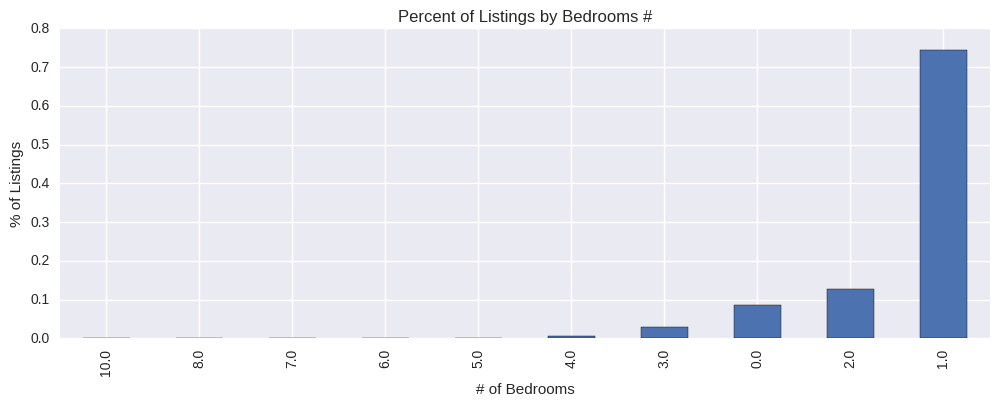

In [21]:
bedrooms_counts = Counter(x.bedrooms)
tdf = pd.DataFrame.from_dict(bedrooms_counts, orient='index').sort_values(by=0)
tdf = tdf.iloc[-10:, :] / 27392

print tdf

ax = tdf.plot(kind='bar', figsize = (12,4))
ax.set_xlabel("# of Bedrooms")
ax.set_ylabel("% of Listings")
ax.set_title('Percent of Listings by Bedrooms #')
ax.legend_.remove()

plt.show()

Let's remove entries (rows) that have faulty data like when
- There are 0 bedrooms
- There are 0 bathrooms
- There are 0 beds
- The price is $0

In [22]:
# Delete bad entries
x = x[x.bedrooms != 0]
x = x[x.beds != 0]
x = x[x.bathrooms != 0]
x = x[x.price != 0]

# Delete additional entries with NaN values
x = x.dropna(axis=0)

print 'Size of trimmed data: ', x.shape

Size of trimmed data:  (16446, 40)


We also need to drop the dollar sign from our price and turn the type into a float.

In [23]:
# Convert $ to float for 'price'
x['price'] = x['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

# Convert $ to float for 'extra people'
x['extra_people'] = x['extra_people'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

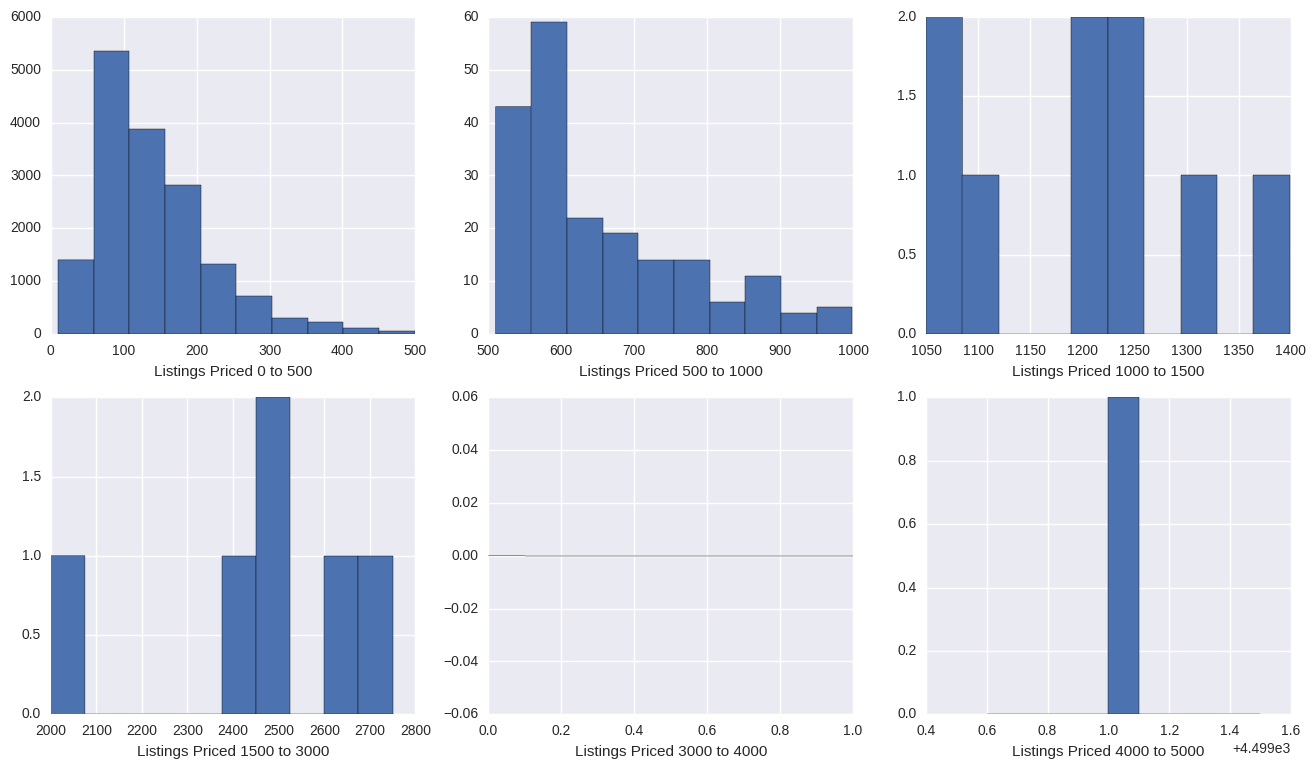

In [24]:
zero_fivehundred = x[x['price'] < 500]
five_thousand = x[(x['price'] > 500) & (x['price'] < 1000)]
thousand_fifteen = x[(x['price'] > 1000) & (x['price'] < 1500)]
fifteen_three = x[(x['price'] > 1500) & (x['price'] < 3000)]
three_four = x[(x['price'] > 3000) & (x['price'] < 4000)]
four_five = x[(x['price'] > 4000) & (x['price'] < 5000)]

# Let's get a feel for our data
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (16,9))

BINS = 10

ax1.hist(zero_fivehundred['price'], bins=BINS)
ax1.set_xlabel('Listings Priced 0 to 500')
ax2.hist(five_thousand['price'], bins=BINS)
ax2.set_xlabel('Listings Priced 500 to 1000')
ax3.hist(thousand_fifteen['price'], bins=BINS)
ax3.set_xlabel('Listings Priced 1000 to 1500')
ax4.hist(fifteen_three['price'], bins=BINS)
ax4.set_xlabel('Listings Priced 1500 to 3000')
ax5.hist(three_four['price'], bins=BINS)
ax5.set_xlabel('Listings Priced 3000 to 4000')
ax6.hist(four_five['price'], bins=BINS)
ax6.set_xlabel('Listings Priced 4000 to 5000')


plt.show()

For a map visualization, say we want generally even sized buckets, each of which will map to a color. By looking at our histograms let's have our buckets the intervals of [0,50,100,150,250,500,10000].

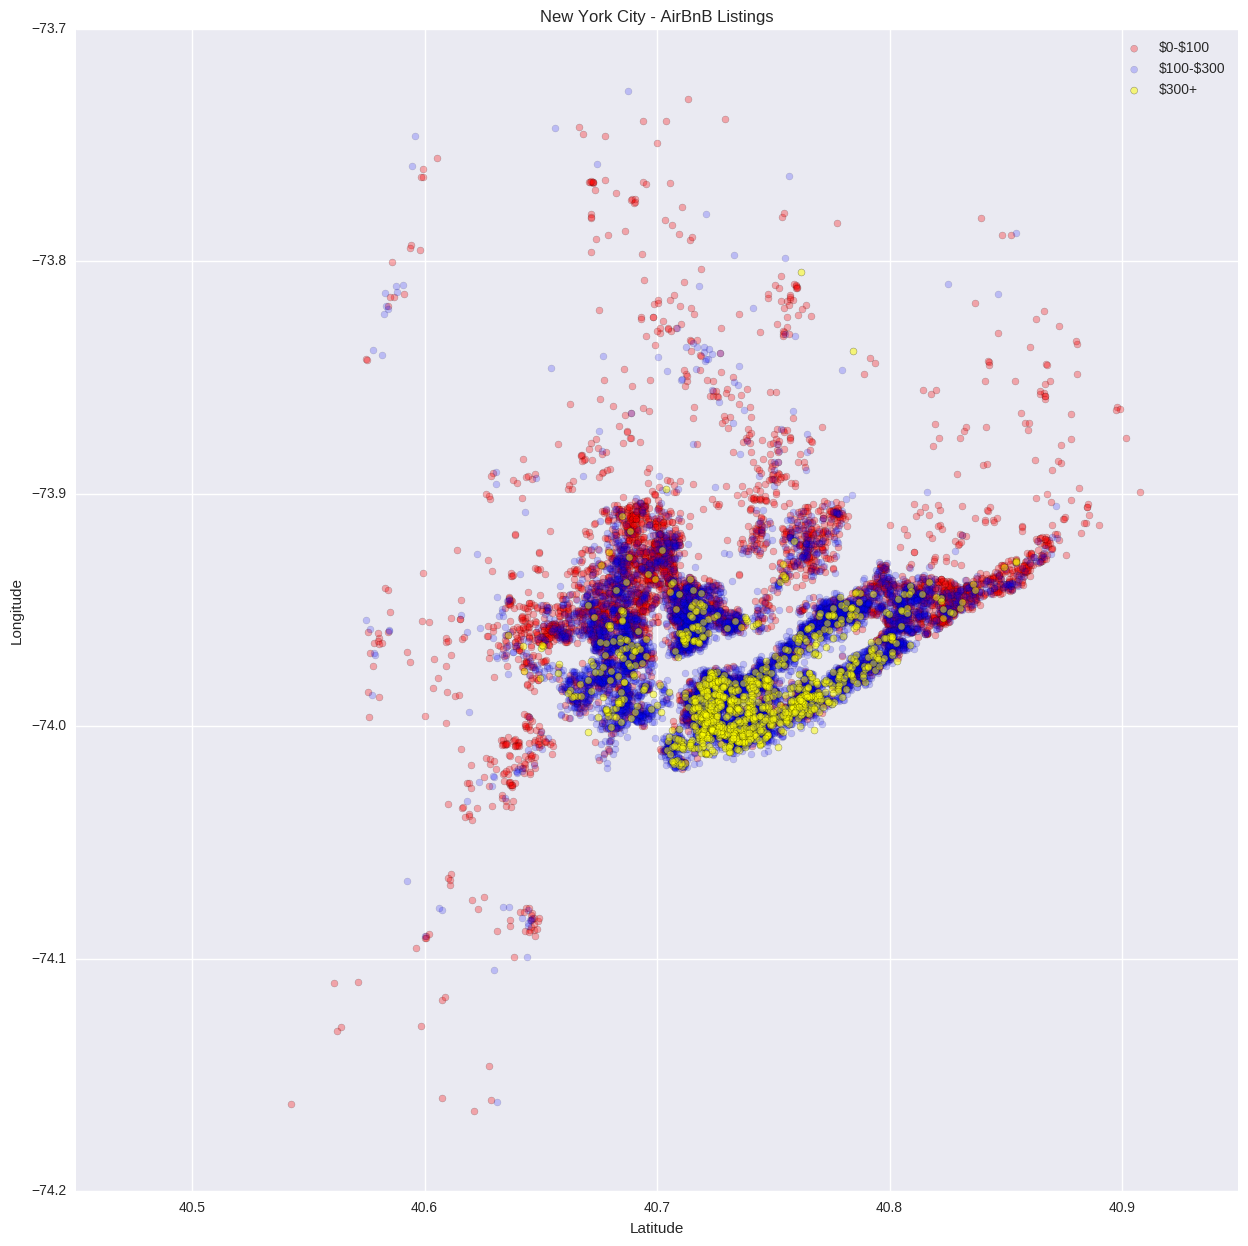

In [25]:
# Outline price buckets
intervals = [0,100,300,10000]
leg_labels = []

# Get Labels for Legend
for i in range(0,len(intervals) - 1):
    if i == len(intervals) - 2:
        leg_labels.append('\${}+'.format(intervals[i]))
    else:
        leg_labels.append("\${}-\${}".format(intervals[i], intervals[i+1]))    

buckets = []

# Divide up into buckets
for i in range(0, len(intervals) - 1):
    buckets.append(x[(x['price'] > intervals[i]) & (x['price'] < intervals[i+1])])

colors = ['red', 'blue', 'yellow', 'cyan', 'pink', 'purple']
alphas = [.3,.2,.5,1,.4,.2]  

# Plot listings on scatter
plt.figure(figsize=(15, 15))
for i in range(0, len(buckets)):
    plt.scatter(buckets[i]['latitude'], buckets[i]['longitude'], alpha = alphas[i], c=colors[i], s=25)
    
plt.title('New York City - AirBnB Listings')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(labels=leg_labels, loc = 'best')
plt.ylim(-74.2,-73.7)
plt.xlim(40.45,40.95)

plt.show()

### Find Listings on Central Park:

In [31]:
streets = x['street'].tolist()
streets_cleansed = []

# Clean Street Data
for street in streets:
    i = street.find(',')
    streets_cleansed.append(street[:i])

x['streets_cleansed'] = streets_cleansed

# List of Streets on Central Park
park_streets = ['West 110th Street', 'W 110th St', '5th Ave', '5th Avenue', 'Central Park', 
                'Central Park South', 'Central Park West', 'Central Park North', 'Central Park East', 'West 59th Street']

x['on_park'] = x['streets_cleansed'].isin(park_streets)

park = x[x['on_park'] == True]

In [34]:
verts = [
    (-73.958546, 40.801266),
    (-73.948807, 40.797251),
    (-73.972904, 40.764011),
    (-73.982735, 40.767682),
    (0., 0.), # ignored
        ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)
patch = patches.PathPatch(path,facecolor = 'none', lw=2)

on_park = []
for index, row in x.iterrows():
    on_park.append(path.contains_point((row['longitude'], row['latitude']) , radius = -.002))

    
x['on_park'] = on_park
park = x[x['on_park'] == True]

print park.shape

# Remove non-exact entries
park = park[park['is_location_exact'] == 't']
print park.shape

(257, 42)
(242, 42)


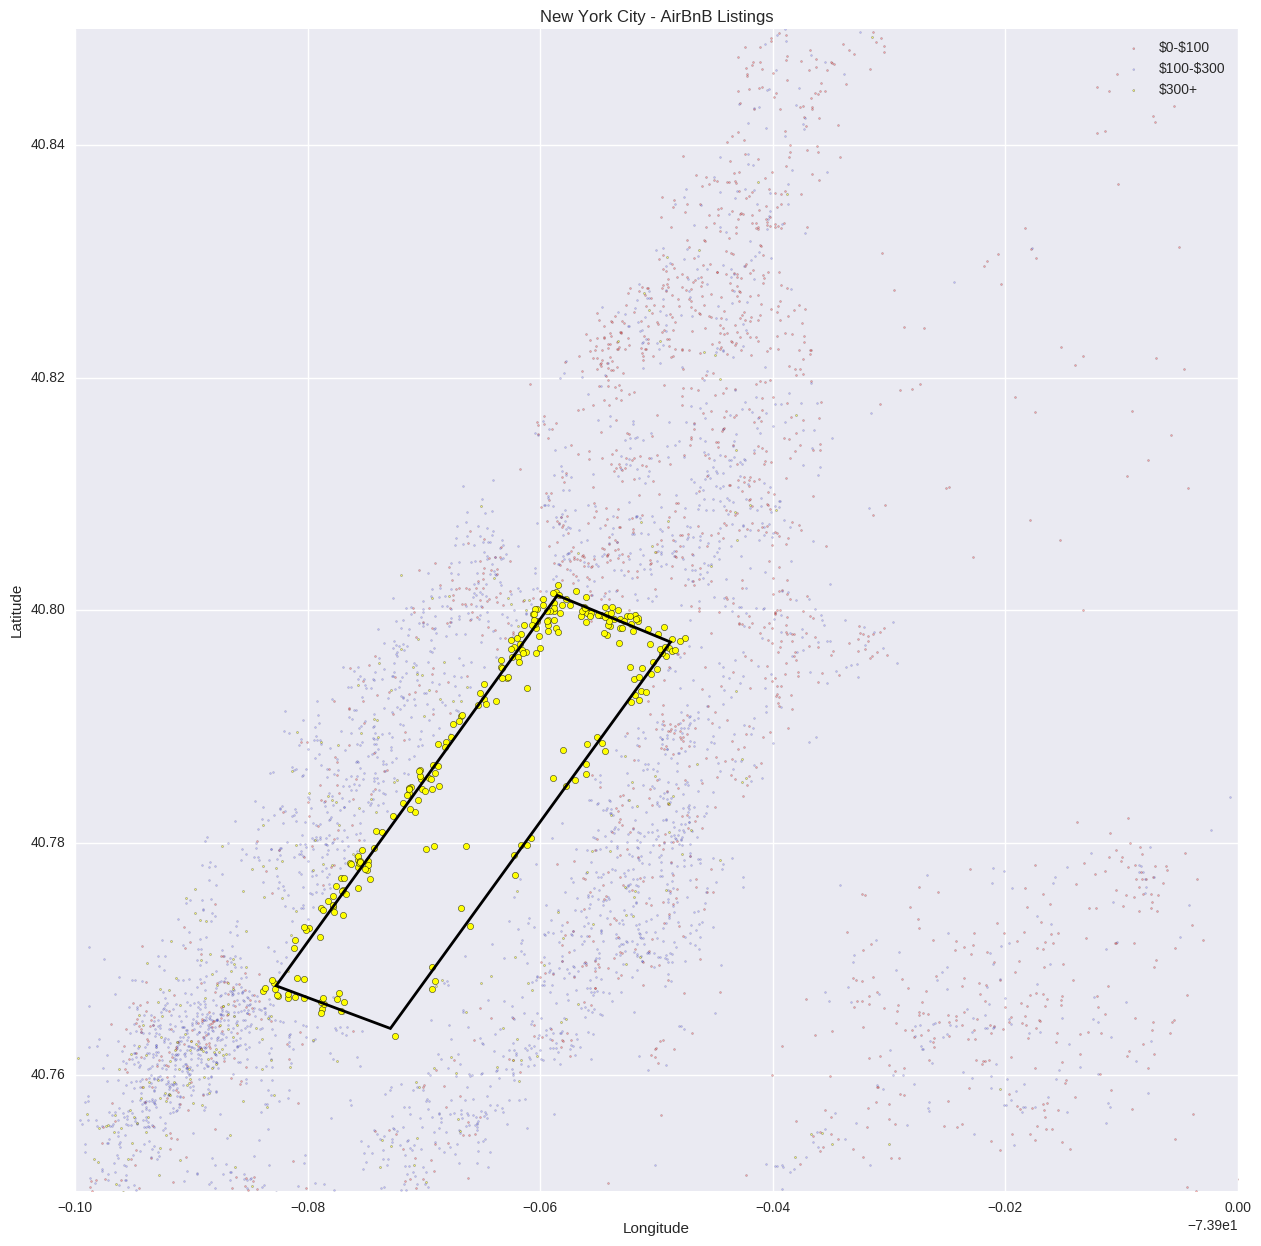

In [35]:
# Plot listings on scatter
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

# Plot all listings by price bucket
for i in range(0, len(buckets)):
    ax.scatter(buckets[i]['longitude'], buckets[i]['latitude'], alpha = alphas[i], c=colors[i], s=2)

# Plot Central Park Listings
ax.scatter(park['longitude'], park['latitude'], s=20, alpha = 1, c='yellow')

# Figure attributes
ax.set_title('New York City - AirBnB Listings')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(labels=leg_labels, loc = 'best')
ax.add_patch(patch)
ax.set_xlim(-74,-73.9)
ax.set_ylim(40.75,40.85)

plt.show()

In [ ]:
# encode_categorical
# 
# Function to label encode categorical variables.
#     Input: array (array of values)
#     Output: array (array of encoded values)
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array

new_x = x.apply(encode_categorical)

In [ ]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(new_x.T)

pd.DataFrame(data = corr_matrix, columns = new_x.columns, index = new_x.columns)

In [ ]:
# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(new_x.T)

# Display heat map 
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.xlabel('Predictor Index')
plt.ylabel('Predictor Index')
plt.title('Heatmap of Correlation Matrix')
plt.colorbar()

plt.show()

We notice that there is a high correlation between all of the availability features. Availability 365 has the lowest correlation to the others, so opt to keep it.

In [ ]:
del new_x['availability_30']
del new_x['availability_60']
del new_x['availability_90']

Because we are doing OLS for our baseline regression, we must have only numerical predictors and so we must also one-hot encode our categorical variables. We also get rid of a number of the categorical variables that have too many unique combinations when one-hot encoded.

In [ ]:
del new_x['id']
del new_x['host_id']
del new_x['host_name']
del new_x['street']
del new_x['name']

In [ ]:
# Apply one hot endcoing
#categorical = (new_x.dtypes.values != np.dtype('float64'))

#encoder = preprocessing.OneHotEncoder(categorical_features = categorical, sparse = False)  # Last value in mask is y
#new_x = encoder.fit_transform(new_x)

In [ ]:
#print new_x.shape

We can see that one-hot encoding brought our number of features from 13 to 197. In actuality and as a quick sanity check, the only categorical variables are 'property_type', 'room_type', and 'neighbourhood_cleansed' and there are 186 neighbourhoods so this makes sense.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(new_x.drop('price', axis = 1), new_x.price, test_size=0.2, random_state = 41)

### Baseline OLS Model

In [ ]:
linreg = LinReg()
linreg.fit(X_train,Y_train)
training_set_score = linreg.score(X_test,Y_test)
print 'The R^2 score on our training data is: ' + str(round(training_set_score,3))

In [ ]:
# stores the coefficient values of the predictors
#coefficient_values = np.array(linreg.coef_)

# stores the names of the variables
#variable_names = X_train.columns.values

# creates table storing the coefficient values and variable names
#coef_matrix = pd.DataFrame({'CoefValues':coefficient_values, 'VarName': variable_names, 'AbsCoef': abs(coefficient_values)})

Below is a table that contains the sorted coefficient values for each variable that we decided to include.

In [ ]:
#sorted_coef_matrix = coef_matrix.sort(columns='AbsCoef').drop('AbsCoef', axis=1)
#sorted_coef_matrix

As we can see, our three categorical features have the same weight despite their encodings – this would likely not be the case in a non-linear model and will be interesting to explore.

### Ridge Model (Tuned)

In [ ]:
lambdas = 10.**np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])

#Perform Ridge regression using expanded set of predictors, 
#choose best regularization parameter lambda using 5-fold x-validation
ridge = RidgeCV(alphas=lambdas, fit_intercept=False, normalize=True, cv=5)
ridge.fit(X_train, Y_train)
ridge.score(X_test, Y_test)

### Baseline Lasso Model (Tuned)

In [ ]:
#Perform Lasso regression using expanded set of predictors, 
#choose best regularization parameter lambda using 5-fold x-validation
lasso = LassoCV(alphas=lambdas, tol=0.01, fit_intercept=False, normalize=True, cv=5)
lasso.fit(X_train, Y_train)
lasso.score(X_test, Y_test)

### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)

In [ ]:
### Random Forest Regressor After Tuning with GridSearchCV

In [ ]:
n_est = 20

tuned_parameters = {
    "n_estimators": [ n_est ]
}

rf_tuned = GridSearchCV(rf, cv=3, param_grid=tuned_parameters)
preds = rf_tuned.fit(X_train, Y_train)
best = rf_tuned.best_estimator_ 
rf_tuned.score(X_test, Y_test)

### Ada Boost Regressor

In [ ]:
ada = AdaBoostRegressor(base_estimator=rf_tuned, n_estimators=10)
ada.fit(X_train, Y_train)
ada.score(X_test, Y_test)

### Ada Boost Regressor After Tuning with GridSearchCV

In [ ]:
n_est = 10

tuned_parameters = {
    "base_estimator": [ rf_tuned ],
    "n_estimators": [ n_est ],
    "learning_rate": [ 0.01 ],
    "loss" : [ 'linear' ]
}

clf = GridSearchCV(ada, cv=3, param_grid=tuned_parameters)
preds = clf.fit(X_train, Y_train)
best = clf.best_estimator_ 
clf.score(X_test, Y_test)

### $R^{2}$ Values Across Different Models

In [ ]:
rs = 1
ests = [linreg, ridge, lasso, rf, ada, clf]
est_labels = np.array(['OLS','Ridge Tuned','Lasso Tuned', 'RF', 'AB (RF)', 'AB Tuned (RF)'])
errvals = np.array([0.537, 0.534, 0.522, 0.57, 0.633, 0.651])

#for e in ests:
    #e.fit(X_train, Y_train)
    #this_err = e.score(X_test, Y_test)
    #errvals = np.append(errvals, this_err)
    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,10))
plt.bar(pos, errvals[srt], align = 'center', color='#E35A5C')
plt.xticks(pos, est_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('R^2 Value')
plt.title('R^2 Model Comparison')
plt.show()

### Variable Importance

In [ ]:
feature_importance = rf_tuned.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) - 1
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize = (8,12))
plt.barh(pos, pvals, align = 'center', color ='#E35A5C')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Predictor Importance Importance')
plt.show()

### Seasonality Data

In [ ]:
calendar_dates = np.array(calendar['date'].unique())

seasonality_data = np.empty([len(calendar_dates),1])
median_seasonality_data = np.empty([len(calendar_dates),1])

index = 0

for item in calendar_dates:
    calendar_dates[index] = datetime.strptime(item,'%m/%d/%Y').date()
    seasonality_data[index, 0] = np.mean(calendar['price'].loc[calendar['date'] == item])
    index += 1
    
for i in range(len(seasonality_data)):
    median_seasonality_data[i] = np.median(seasonality_data)

In [ ]:
fig, ax = plt.subplots()

ax.plot(calendar_dates, seasonality_data, label='Data')
ax.plot(calendar_dates, median_seasonality_data, label='Median', linestyle='-')
ax.plot(calendar_dates, avg_week_price)
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Average Nightly Price (USD)')
ax.set_title('Average Nightly Price in 2015')

plt.figure(figsize = (10,10))
plt.show()

In [ ]:
test_score = best.staged_score(X_test, Y_test)
train_score = best.staged_score(X_train,Y_train)

test_score_array = []
train_score_array = []

for i in test_score:
    test_score_array.append(i)

for i in train_score:
    train_score_array.append(i)
    
plt.figure(figsize=(7, 7))

plt.scatter(range(1,11), test_score_array, label = 'Testing Data', color ='#E35A5C')
plt.scatter(range(1,11), train_score_array, label = 'Training Data', color ='#79CCCD')
plt.title('Performance Over Boosting Iterations')
plt.xlabel('Boosting Iterations')
plt.ylabel('R^2')
plt.legend(loc = 'best')

plt.show()